# Convolutional Neural Network (CNN)

### Importando as Bibliotecas


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/TCC-NATALIA'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        pass

/content/drive/MyDrive/TCC-NATALIA/200181.pdf
/content/drive/MyDrive/TCC-NATALIA/BackLog.gsheet
/content/drive/MyDrive/TCC-NATALIA/MODELO A SER SEGUIDO.pdf
/content/drive/MyDrive/TCC-NATALIA/peerj-10309 -INSERIDO.pdf
/content/drive/MyDrive/TCC-NATALIA/INSERIDO - PAM-DenseNet_A_Deep_Convolutional_Neural_Network_for_Computer-Aided_COVID-19_Diagnosis.pdf
/content/drive/MyDrive/TCC-NATALIA/TCC-NATALIA.ipynb
/content/drive/MyDrive/TCC-NATALIA/TCC - PARTE ESCRITA/ATA.pdf
/content/drive/MyDrive/TCC-NATALIA/TCC - PARTE ESCRITA/Tutorial Discente_Inserir Lattes no SUAP.pdf
/content/drive/MyDrive/TCC-NATALIA/TCC - PARTE ESCRITA/CONICT_2021_Modelo_Resumo_Expandido_WORD_CORRECAO_NATALIA_ANAPAULA_V2.docx
/content/drive/MyDrive/TCC-NATALIA/TCC - PARTE ESCRITA/anotaçoes.docx
/content/drive/MyDrive/TCC-NATALIA/TCC - PARTE ESCRITA/testando outras camadas de ativacao.docx
/content/drive/MyDrive/TCC-NATALIA/TCC - PARTE ESCRITA/Modelo_Artigo_Sinergia.doc
/content/drive/MyDrive/TCC-NATALIA/TCC - PARTE ESCR

In [ ]:
data_path = '/content/drive/MyDrive/TCC-NATALIA'

In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/TCC-NATALIA/Teste/Teste.zip','r') as zip:
      zip.extractall((data_path+'./'))

  


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_path + '/Teste/Teste',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1382 files belonging to 3 classes.
Using 1106 files for training.


In [ ]:

with zipfile.ZipFile('/content/drive/MyDrive/TCC-NATALIA/Ativacao/ativacao.zip','r') as zip:
    zip.extractall((data_path+'./'))

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/TCC-NATALIA./ativacao',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5174 files belonging to 3 classes.
Using 1034 files for validation.


In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

#alterei o trainimage para directory=r e funcionou
training_set=train_datagen.flow_from_directory(directory=r"./",target_size=(180,180),batch_size=32,class_mode='categorical')

Found 8466 images belonging to 3 classes.


In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Pneumonia']


## Visualização dos dados



*   As 9 primeiras imagens do conjunto de dados



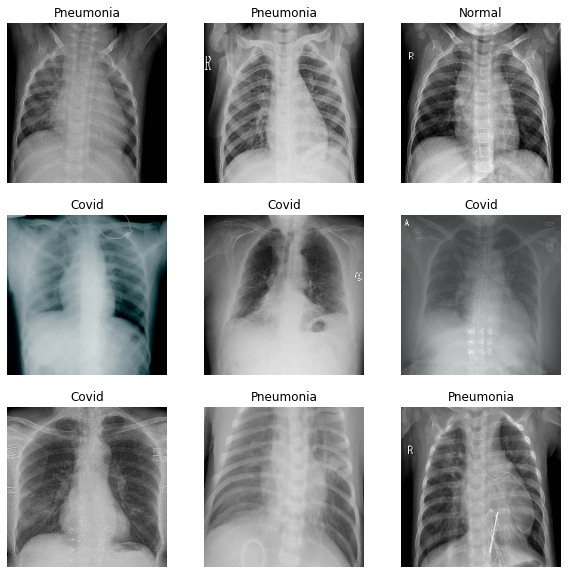

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Aumento dos dados da imagem

In [ ]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)



*   As imagens após o aumento aleatório



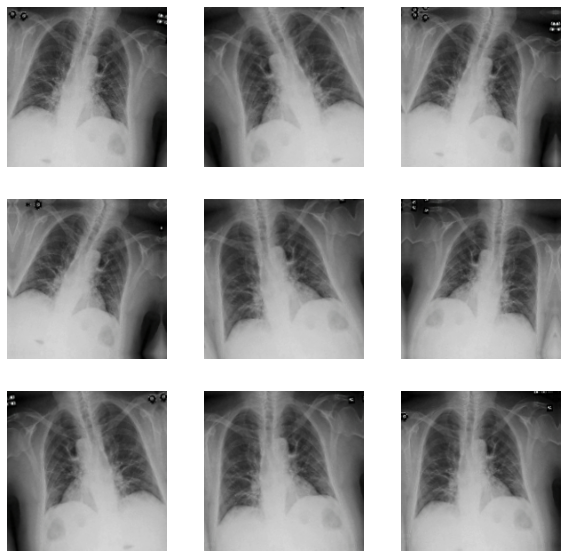

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Configurando o conjunto de dados para o desempenho

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### Construção do Modelo

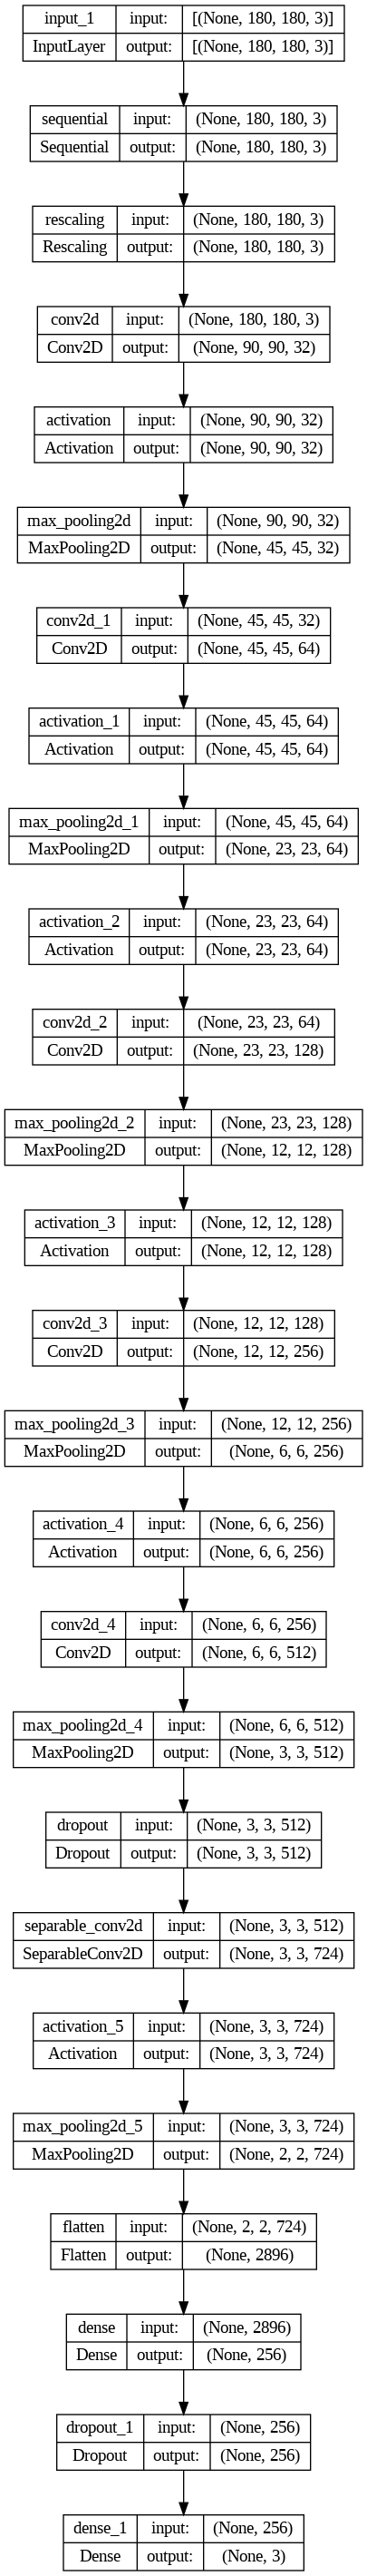

In [ ]:
keras.backend.clear_session()
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)




### Definindo Callbacks

In [ ]:
checkpoint_filepath = '/content/content'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
    save_weights_only=True,
         monitor='val_accuracy',
  mode='max',
     save_best_only=True)
#possivelmente esta parando devido aqui
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Treinando o modelo

In [ ]:
epochs = 25

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(
    train_ds, epochs = epochs, 
    callbacks = [early_stop, lr_callback],
    validation_data = val_ds)

Epoch 1/25


35/35 [==============================] - 246s 7s/step - loss: 0.9715 - accuracy: 0.6148 - val_loss: 0.8700 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 2/25
35/35 [==============================] - 164s 5s/step - loss: 0.9085 - accuracy: 0.6257 - val_loss: 0.7955 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 3/25
35/35 [==============================] - 165s 5s/step - loss: 0.8679 - accuracy: 0.6248 - val_loss: 0.7269 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 4/25
35/35 [==============================] - 153s 4s/step - loss: 0.7226 - accuracy: 0.6682 - val_loss: 1.0429 - val_accuracy: 0.3240 - lr: 0.0010
Epoch 5/25
35/35 [==============================] - 162s 4s/step - loss: 0.5475 - accuracy: 0.7414 - val_loss: 0.5077 - val_accuracy: 0.7834 - lr: 0.0010
Epoch 6/25
35/35 [==============================] - 167s 5s/step - loss: 0.4015 - accuracy: 0.8282 - val_loss: 0.4606 - val_accuracy: 0.8308 - lr: 0.0010
Epoch 7/25
35/35 [==============================] - 161s 4s/step - loss: 0.3889 - accur

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 32)        2432      
                                                                 
 activation (Activation)     (None, 90, 90, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                             

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation Accuracy')

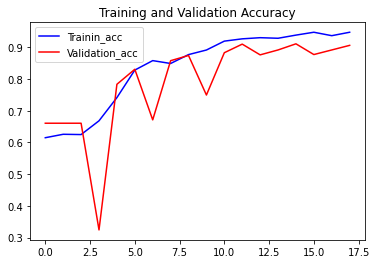

In [ ]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

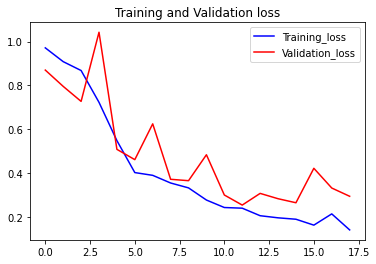

In [ ]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

In [ ]:
class_dict = {2:'COVID19',
              0:'NORMAL',
              1:'PNEUMONIA'}

In [ ]:
image_path = "../content/drive/MyDrive/TCC-NATALIA./ativacao/Covid/COVID19(463).jpg"
image_path2 = "../content/drive/MyDrive/TCC-NATALIA./ativacao/Normal/NORMAL(1268).jpg"
image_path3 = "../content/drive/MyDrive/TCC-NATALIA./ativacao/Pneumonia/PNEUMONIA(3423).jpg"
image_path4 = "../content/drive/MyDrive/TCC-NATALIA./ativacao/Covid/COVID19(464).jpg"
image_path5 = "../content/drive/MyDrive/TCC-NATALIA./ativacao/Normal/NORMAL(1270).jpg"
image_path6 = "../content/drive/MyDrive/TCC-NATALIA./ativacao/Pneumonia/PNEUMONIA(3426).jpg"
image_path7 = "../content/drive/MyDrive/TCC-NATALIA./ativacao/Covid/COVID19(465).jpg"
image_path8 = "../content/drive/MyDrive/TCC-NATALIA./ativacao/Normal/NORMAL(1261).jpg"
image_path9 = "../content/drive/MyDrive/TCC-NATALIA./ativacao/Pneumonia/PNEUMONIA(3420).jpg"
merged_path = [image_path,image_path2,image_path3,image_path4,image_path5,image_path6,image_path7,image_path8,image_path9]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    pred_class = np.argmax(predictions)

    pred_class = class_dict[pred_class]

    
    print(
        "Essa imagem provavelmente pertence a {} com uma confiança de {:.2f} por cento."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))
    print('prediction: ',pred_class)

1/1 [==============================] - 0s 221ms/step
Essa imagem provavelmente pertence a Covid com uma confiança de 49.30 por cento.
prediction:  NORMAL
1/1 [==============================] - 0s 52ms/step
Essa imagem provavelmente pertence a Normal com uma confiança de 50.01 por cento.
prediction:  PNEUMONIA
1/1 [==============================] - 0s 54ms/step
Essa imagem provavelmente pertence a Pneumonia com uma confiança de 57.56 por cento.
prediction:  COVID19
1/1 [==============================] - 0s 58ms/step
Essa imagem provavelmente pertence a Covid com uma confiança de 55.62 por cento.
prediction:  NORMAL
1/1 [==============================] - 0s 61ms/step
Essa imagem provavelmente pertence a Normal com uma confiança de 46.69 por cento.
prediction:  PNEUMONIA
1/1 [==============================] - 0s 52ms/step
Essa imagem provavelmente pertence a Pneumonia com uma confiança de 51.90 por cento.
prediction:  COVID19
1/1 [==============================] - 0s 61ms/step
Essa imagem